## Final project - Data Mining and Analysis
### Part 2
#### `Team Volvo`
#### *Nadav Yedid*
#### *Roee Brown*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import math
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import ppscore as pps
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error as mse, r2_score
from scipy import sparse, stats
from html import unescape

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("dataset.csv")
cars_df = data.copy()
cars_df.sample(3)

,manufactor,Year,model,Hand,Gear,capacity_Engine,Engine_type,Prev_ownership,Curr_ownership,Area,City,Price,Pic_num,Cre_date,Repub_date,Description,Color,Km,Test,Supply_score
1061,פולקסווגן,2011,שירוקו,4,אוטומטית,1390,בנזין,NaN,NaN,NaN,פקיעין,46000.0,1.0,09/09/2022,09/09/2022,"['רכב שמור \r\n160כ""ס\r\nעם מערכת']",NaN,257,NaN,NaN
1035,מאזדה,2013,מאזדה 3,3,אוטומטית,2000,בנזין,חברה,פרטית,קיסריה והסביבה,אור עקיבא,24000.0,2.0,12/07/2023,12/07/2023,['מזדה 3 מנוע 2000 הדגם עם 150 כוח סוס\nמתחייב...,שחור,200000,NaN,736.0
571,הונדה,2011,סיוויק,4,אוטומטית,1800,בנזין,לא מוגדר,לא מוגדר,עכו - נהריה,עכו,30000.0,1.0,27/10/2022,27/10/2022,"['רכב מסוג הונדה סיוויק 2011, הרכב נסע 147,445...",NaN,147445,NaN,NaN


In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   manufactor       1500 non-null   object 
 1   Year             1500 non-null   int64  
 2   model            1500 non-null   object 
 3   Hand             1500 non-null   int64  
 4   Gear             1499 non-null   object 
 5   capacity_Engine  1474 non-null   object 
 6   Engine_type      1495 non-null   object 
 7   Prev_ownership   774 non-null    object 
 8   Curr_ownership   774 non-null    object 
 9   Area             1361 non-null   object 
 10  City             1500 non-null   object 
 11  Price            1500 non-null   float64
 12  Pic_num          1476 non-null   float64
 13  Cre_date         1500 non-null   object 
 14  Repub_date       1500 non-null   object 
 15  Description      1500 non-null   object 
 16  Color            787 non-null    object 
 17  Km            

#### A function that remove duplicte rows:

In [4]:
def remove_duplicates(df):
    df = df.drop_duplicates()
    
    return df

#### According to what we have seen, there are duplicates in the names of the manufacturers and models.
#### Therefore, we built functions that would unify the names:

In [5]:
def unify_manufacturer(df, column_name = "manufactor"):

    df[column_name] = df[column_name].replace("Lexsus", "לקסוס")
    
    return df

In [6]:
def modify_model_name(df, column_name = "model"):
    manufacturers = ['יונדאי', 'ניסאן', 'סוזוקי', 'טויוטה', 'קיה', 'אאודי', 'סובארו',
       'מיצובישי', 'מרצדס', 'ב.מ.וו', 'אופל', 'הונדה', 'פולקסווגן',
       'שברולט', 'מאזדה', 'וולוו', 'סקודה', 'פורד', 'לקסוס', 'קרייזלר',
       'סיטרואן', "פיג'ו", 'רנו', 'דייהטסו', 'מיני', 'אלפא רומיאו']
    
    # Define the pattern to remove manufacturer names at the beginning or end
    pattern = r'\b(?:' + '|'.join(manufacturers) + r')\b'
    
    # Apply the regex substitution to remove manufacturer names and trim spaces
    df[column_name] = df[column_name].apply(lambda x: re.sub(pattern, '', x.strip().replace('`', "'")).strip())
    
    # Remove years in parentheses from the model names
    df[column_name] = df[column_name].apply(lambda x: re.sub(r'\s*\(\d{4}\)', '', x))
    
    return df

In [7]:
def unify_model_names(df, column_name = "model"):
    replacements = {
        "CIVIC": "סיוויק",
        "C-Class קופה": "C-Class",
        "C-CLASS קופה": "C-Class",
        "E- CLASS": "E-Class",
        "E-Class קופה / קבריולט": "E-Class",
        "מיטו / MITO": "מיטו",
        "גראנד, וויאג`ר": "גראנד, וויאג'ר",
        "וויאג`ר": "וויאג'ר",
        "GS300": "GS300",
        "IS250": "IS250",
        "IS300H": "IS300H",
        "IS300h": "IS300H",
        "RC": "RC",
        "CT200H": "CT200H",
        "ג'וק JUKE": "ג'וק",
        "סיטיגו / Citygo": "סיטיגו",
        "ACCORD": "אקורד"}
    
    df.loc[:, column_name] = df[column_name].replace(replacements)    
    
    return df

> #### We chose to fill in the missing values in the Gear column according to the most common type of gear in that vehicle model.
> #### If the value is still missing, we will fill it according to the most common gear type for each manufacturer.
> #### In addition, we combined the values "אוטומט" & "אוטומטית".

In [8]:
def fill_Gear(df, column_name = "Gear", model_column = "model", manufactor_column = "manufactor"):

    df[column_name] = df[column_name].replace("אוטומט", "אוטומטית")
    
    most_common_model = df.groupby(model_column)[column_name].agg(lambda x: x.mode().iloc[0]
                                                                                 if not x.mode().empty
                                                                                 else None)
    
    df[column_name] = df.apply(lambda row: most_common_model[row[model_column]]
                               if pd.isnull(row[column_name])
                               else row[column_name], axis = 1)
    
    most_common_manufactor = df.groupby(manufactor_column)[column_name].agg(lambda x: x.mode().iloc[0]
                                                                                           if not x.mode().empty
                                                                                           else None)
    
    df[column_name] = df.apply(lambda row: most_common_manufactor[row[manufactor_column]]
                               if pd.isnull(row[column_name])
                               else row[column_name], axis = 1)
    
    return df

> #### In the column of capacity_engine, we chose to fill in missing values in the average engine capacity according to the vehicle model.
> #### Then, if there were still missing values, we filled in the values with the average engine volume by manufacturer.

In [9]:
def modify_capacity_engine(df, column_name = "capacity_Engine"):
   
    try:
        df[column_name] = pd.to_numeric(df[column_name].str.replace(',', ''), errors = "coerce").round(2)
    except AttributeError:
        df[column_name] = pd.to_numeric(df[column_name], errors = "coerce").round(2)
    
    if df[column_name].isnull().any():
        average_model = df.groupby("model")[column_name].transform("mean")
        
        df[column_name].fillna(average_model, inplace = True)
        
    if df[column_name].isnull().any():
        average_manufactor = df.groupby("manufactor")[column_name].transform("mean")
        
        df[column_name].fillna(average_manufactor, inplace = True)
    
    return df

> #### We chose to fill in the missing values in the Engine_type column according to the most common type of engine type in that vehicle model.
> #### If the value is still missing, we will fill it according to the most common engine type type for each manufacturer.
> #### In addition, we combined the values "היבריד" & "היברידי".

In [10]:
def fill_engine_types(df, column_name = "Engine_type", model_column = "model", manufactor_column = "manufactor"):

    df[column_name] = df[column_name].replace("היברידי", "היבריד")
    
    most_common_model = df.groupby(model_column)[column_name].agg(lambda x: x.mode().iloc[0]
                                                                                 if not x.mode().empty
                                                                                 else None)
    
    df[column_name] = df.apply(lambda row: most_common_model[row[model_column]]
                               if pd.isnull(row[column_name])
                               else row[column_name], axis = 1)
    
    most_common_manufactor = df.groupby(manufactor_column)[column_name].agg(lambda x: x.mode().iloc[0]
                                                                                           if not x.mode().empty
                                                                                           else None)
    
    df[column_name] = df.apply(lambda row: most_common_manufactor[row[manufactor_column]]
                               if pd.isnull(row[column_name])
                               else row[column_name], axis = 1)
    
    return df

> #### According to what we have seen, there are many values that are defined as unknown.
> #### Therefore, we decided to define the missing values as unknown as well.

In [11]:
def fill_ownership(df, column_name = ["Prev_ownership", "Curr_ownership"]):
    replacements = {
        "None": "לא מוגדר",
        np.nan: "לא מוגדר"}
    
    df[column_name] = df[column_name].replace(replacements)
    
    return df

#### A function that combines names of cities:

In [12]:
def unify_city_names(df, column_name = "City"):
    replacements = {
        "Rishon LeTsiyon": "ראשון לציון",
        "Tel aviv": "תל אביב",
        "Tzur Natan": "צור נתן",
        "ashdod": "אשדוד",
        "haifa": "חיפה",
        "Rehovot": "רחובות",
        "jeruslem": "ירושלים",
        "בית ג'ן": "בית ג'אן",
        "גבעתיי": "גבעתיים",
        "גבעתי": "גבעתיים",
        "חיפ": "חיפה", 
        "טירת כרמל": "טירת הכרמל",
        "יוקנעם עילית": "יקנעם עילית",
        "נהרייה": "נהריה",
        "נתנייה": "נתניה",
        "פתח תיקווה": "פתח תקווה",
        "פתח": "פתח תקווה",
        "פתח תקווה,יהוד": "פתח תקווה",
        "ק.אתא": "קרית אתא",
        "קריית אתא": "קרית אתא",
        "קריית ביאליק": "קרית ביאליק",
        "קריית טבעון": "קרית טבעון",
        "קריית ים": "קרית ים",
        "ראשון": "ראשון לציון",
        "תל אבייב": "תל אביב",
        "תל אביב יפו": "תל אביב"}
    
    df.loc[:, column_name] = df[column_name].replace(replacements)    
    
    return df

#### We chose to fill in the missing values of the number of images according to the total median value of the number of the images.

In [13]:
def fill_Pic_num(df, column_name = "Pic_num"):
    
    median_photos = df[column_name].median()
    median_photos_rounded_down = math.floor(median_photos)
    
    df[column_name].fillna(median_photos_rounded_down, inplace = True)
    
    return df

In [14]:
def fill_Color(df, column_name = "Color"):
    replacements = {
        "None": "לא מוגדר",
        np.nan: "לא מוגדר"}
    
    df[column_name] = df[column_name].replace(replacements)
    
    return df

#### A function that replaces the NaN and "0" values in the Km column with the average of the kilometers traveled by that car per year:

In [15]:
def fill_Km(df, column_name = "Km"):
    try:
        df[column_name] = pd.to_numeric(df[column_name].str.replace(',', ''), errors = "coerce")
    except AttributeError:
        df[column_name] = pd.to_numeric(df[column_name], errors = "coerce")
    
    df[column_name] = df[column_name].replace(0, np.nan)
    
    if df[column_name].isnull().any():
        df[column_name] = df[column_name].fillna(((df["Km"] / (2024 - df["Year"])).mean()) * (2024 - df["Year"]))
    
    return df

#### A function that changes the Km values that are lower than 1,000:

In [16]:
def modify_Km(df, column_name = "Km"):
    df[column_name] = df[column_name].apply(lambda x: x * 1000 if x < 1000 else x)
    
    return df

#### A function that cleans the description of unwanted characters:

In [17]:
def clean_description(df, column_name = "Description"):
    
    # Function to clean a single description
    def clean_single_description(column_name = "Description"):
        # Remove HTML tags and entities
        cleaned_desc = re.sub(r'<.*?>', '', column_name)  # Remove HTML tags
        cleaned_desc = unescape(cleaned_desc)  # Convert HTML entities to characters
        
        # Remove extra whitespace
        cleaned_desc = re.sub(r'\s+', ' ', cleaned_desc).strip()
        
        # Optionally, add more cleaning steps as needed
        
        return cleaned_desc
    
    # Apply the cleaning function to each row in the specified column
    df[column_name] = df[column_name].apply(clean_single_description)
    
    return df

#### Fill missing values with the median

In [18]:
def fill_supply_score(df, column_name = "Supply_score"):
    median_supply_score = df[column_name].median()
    
    df[column_name].fillna(median_supply_score, inplace = True)
    
    return df

### <span style = "color:blue" > A function that fills in the missing values: </span>

In [19]:
def data_filling(df):
    df = remove_duplicates(df)
    df = unify_manufacturer(df)
    df = modify_model_name(df)
    df = unify_model_names(df)
    df = fill_Gear(df)
    df = modify_capacity_engine(df)
    df = fill_engine_types(df)
    df = fill_ownership(df)
    df = unify_city_names(df)
    df = fill_Pic_num(df)
    df = fill_Color(df)
    df = fill_Km(df)
    df = modify_Km(df)
    df = clean_description(df)
    df = fill_supply_score(df)
    
    df = df.reset_index(drop = True)
    
    return df

### Adding features:
#### We think that the average number of kilometers per year that the car travels is important for determining its price, so we created a function that will check how many on average the car traveled each year:

In [20]:
def vehicle_usage(df):

    df["Year"] = df["Year"].astype(int)
    
    current_year = pd.Timestamp.now().year
    
    df["Vehicle_Age"] = current_year - df["Year"]
    
    df["Avg_Km_Per_Year"] = (df["Km"] / df["Vehicle_Age"]).round().astype(int)
    
    conditions = [
        (df["Avg_Km_Per_Year"] > 15000),
        (df["Avg_Km_Per_Year"] < 10000),
        (df["Avg_Km_Per_Year"].between(10000, 15000, inclusive = "left"))]
        # inclusive = "left": values equal to 10000 are included, values equal to 15000 are not included.
    
    choices = ["Above Range", "Below Range", "In Range"]
    
    df["Usage_Category"] = np.select(conditions, choices, default = "In Range")
    
    return df

#### We think that the age of the vehicle is important for determining its price, that's why we created a function that will check the age of the vehicle:

In [21]:
def vehicle_age(df):
    current_year = pd.Timestamp.now().year
    
    df['Vehicle_Age'] = current_year - df['Year']
    
    def age_category(age):
        if age < 3:
            return 'Very New'
        elif 3 <= age <= 8:
            return 'New'
        elif 8 < age < 15:
            return 'Reasonable'
        elif 15 < age < 19:
            return 'Old'
        elif 19 <= age <= 30:
            return 'Very Old'
        else:
            return 'Collectors Vehicle'
    
    df['Age_Category'] = df['Vehicle_Age'].apply(age_category)
    
    return df

### <span style = "color:blue" > A function that will insert the new features into the data: </span>

In [22]:
def add_features(df):
    df = vehicle_usage(df)
    df = vehicle_age(df)
    
    return df

#### In order to examine the data in a better way, we decided to filter values that appear relatively rarely in the data.
#### That's why we created a function that filters out values that appear less than 100 times in the data.

In [23]:
def group_low_frequency_categories(df, min_frequency = 100):
    # Select categorical columns
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Group low-frequency categories
    for col in categorical_cols:
        value_counts = df[col].value_counts()
        to_replace = value_counts[value_counts < min_frequency].index
        df[col] = df[col].apply(lambda x: 'Other' if x in to_replace else x)
    
    return df

### Creating a function that converts categorical variables by OneHotEncoder:

In [24]:
def encode_categorical_variables(df):
    # Select categorical columns
    categorical_cols = df.select_dtypes(include = ['object', 'category']).columns.tolist()

    # Create an instance of OneHotEncoder
    encoder = OneHotEncoder(sparse = False, drop = 'first')

    # Fit and transform the categorical columns
    encoded_categorical = encoder.fit_transform(df[categorical_cols])

    # Get feature names from encoder and create new column names
    feature_names = encoder.get_feature_names_out(categorical_cols)

    # Create a DataFrame from the encoded data with column names
    encoded_df = pd.DataFrame(encoded_categorical, columns=feature_names)

    # Drop original categorical columns from the DataFrame
    df_encoded = df.drop(categorical_cols, axis=1)

    # Concatenate the original DataFrame with the encoded DataFrame
    df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

    return df_encoded

### Creating a function to observe the data and extract information from it:

In [25]:
def observe_data(df):
    df = data_filling(df)
    df = add_features(df)
    df = group_low_frequency_categories(df)
    df = encode_categorical_variables(df)
    
    return df

### <span style = "color:blue" > Data processing by observe_data(): </span> 

In [26]:
observed_df = observe_data(cars_df)

### Creating a heat map in order to understand which features contribute the most to the model:

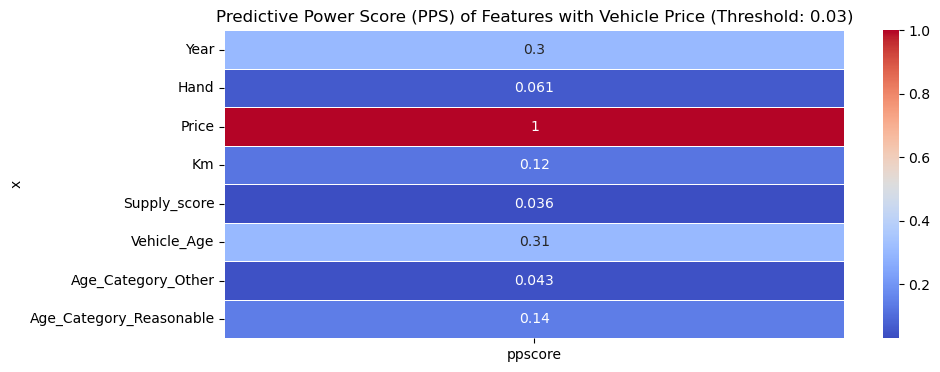

In [27]:
pps_matrix = pps.matrix(observed_df)

threshold = 0.03
pps_price = pps_matrix[(pps_matrix['y'] == 'Price') & (pps_matrix['ppscore'] > threshold)][['x', 'ppscore']].set_index('x')

plt.figure(figsize=(10, 4))
sns.heatmap(pps_price, annot=True, cmap='coolwarm', linewidths=0.5, vmin=threshold)
plt.title(f'Predictive Power Score (PPS) of Features with Vehicle Price (Threshold: {threshold})')
plt.show()

#### - **Year**: The year of manufacture shows a moderate predictive power (PPS = 0.3) in determining the vehicle price.
  
#### - **KM**: The kilometers driven per year have a weaker predictive power (PPS = 0.12) compared to other factors.
  
#### - **Supply**: The availability or supply score of vehicles demonstrates a moderate predictive power (PPS = 0.15) in influencing prices.
  
#### - **Vehicle Age**: The age of the vehicle (Vehicle Age) has a strong predictive power (PPS = 0.31) in determining its price, highlighting its significant impact.

#### - **Age Category**: The category based on vehicle age (Age Category) shows a weaker predictive power (PPS = 0.14) compared to the vehicle's actual age.

In [28]:
observed_X = observed_df.drop('Price', axis = 1)  # Features
observed_y = observed_df['Price']  # Target variable
column_names = observed_X.columns.tolist()

In [29]:
# Calculate VIF for each predictor
vif_values = [variance_inflation_factor(observed_X.values, i) for i in range(observed_X.shape[1])]

# Print column names and corresponding VIF values
for col, vif in zip(column_names, vif_values):
    print(f"{col}: {vif:.2f}")

Year: 229.89
Hand: 1.50
capacity_Engine: 1.22
Pic_num: 1.29
Km: 12.80
Supply_score: 1.16
Vehicle_Age: 38.51
Avg_Km_Per_Year: 11.20
manufactor_הונדה: 1.22
manufactor_יונדאי: 1.15
manufactor_סקודה: 1.15
manufactor_פולקסווגן: 1.14
manufactor_קיה: 2.66
model_פיקנטו: 2.61
Gear_אוטומטית: 1.05
Engine_type_בנזין: 1.19
Prev_ownership_לא מוגדר: 180.76
Prev_ownership_פרטית: 2.99
Curr_ownership_לא מוגדר: inf
Curr_ownership_פרטית: 34.85
Area_ירושלים והסביבה: 3.83
Area_nan: 1.06
City_ירושלים: 3.79
Color_לא מוגדר: inf
Color_לבן: 1.33
Color_שחור: 1.23
Test_nan: 1.11
Usage_Category_Below Range: 2.68
Usage_Category_In Range: 1.94
Age_Category_Other: 3.68
Age_Category_Reasonable: 2.44


## <span style = "color:blue" >Summary of VIF Analysis for Model Features:</span>

#### 1) **High VIF (Above 10)**:
  - **Year**:<span style = "background :yellow"> Shows significant multicollinearity with other variables,</span> suggesting inflated variance in its coefficient estimate. Consider its necessity and apply regularization techniques if retained.

#### 2) **Moderate VIF (Between 5 and 10)**:
  - **Km**:<span style = "background :yellow"> Indicates moderate multicollinearity,</span> which may impact the stability of its coefficient estimate. Evaluate its importance and potential impact on model performance.

#### 3) **Low VIF (Below 5)**:
  - **Hand**, **capacity_Engine**, **Pic_num**, **Supply_score**, **Vehicle_Age**, and most categorical variables:<span style = "background :yellow"> These variables exhibit lower levels of multicollinearity,</span> contributing independently to the model.

## <span style = "color:blue" > The five characteristics with the greatest impact on prediction are: </span>

#### 1) <span style = "background :yellow" > Vehicle_Age:</span> Negative influence. Older vehicles are priced lower.

#### 2) <span style = "background :yellow" > Km:</span>Negative influence.  Higher mileage negatively impacts vehicle prices.

#### 3) <span style = "background :yellow" > Hand:</span> Negative influence. Vehicles with fewer previous owners are generally priced higher.

#### 4) <span style = "background :yellow" > Model:</span> The model of the vehicle has a great significance on its price. Models that are considered better will be significantly more expensive than other models.

#### 5) <span style = "background :yellow" > Description:</span> From the tests we conducted, we found that the description has a strong meaning for the price of the vehicle.

In [30]:
def delete_columns(df):
    columns_to_delete = ["Year", "capacity_Engine", "Engine_type", "Prev_ownership," "Curr_ownership",
                         "Area", "City", "Pic_num", "Cre_date", "Repub_date", "Description", "Test"]
    
    # Only drop columns that exist in the DataFrame
    existing_columns_to_delete = [col for col in columns_to_delete if col in df.columns]
    
    if existing_columns_to_delete:
        df = df.drop(existing_columns_to_delete, axis = 1)
    
    return df

# <span style = "color:blue" > Creating the function prepare_data(): </span>

In [31]:
def prepare_data(df):
    df = data_filling(df)
    df = add_features(df)
    df = delete_columns(df)
    df = encode_categorical_variables(df)
    
    return df

In [32]:
cars_df = prepare_data(cars_df)

# <span style = "color:blue" > Creating the model: </span> 

In [33]:
X = cars_df.drop('Price', axis = 1) # Features
y = cars_df['Price'] # Target variable

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = X_train.toarray() if isinstance(X_train, sparse.csr_matrix) else X_train
X_test = X_test.toarray() if isinstance(X_test, sparse.csr_matrix) else X_test
# If X_train or X_test is a sparse matrix, it will be converted to a dense array.
# If X_train or X_test is already a dense array, it will remain as is.

In [35]:
elastic_net = ElasticNet(random_state = 42)

# Define the grid of hyperparameters
param_grid = {
    'alpha': [0.01, 0.05, 0.15],
    'l1_ratio': [0.7, 0.9]}

# Set up the grid search
grid_search = GridSearchCV(estimator = elastic_net, param_grid = param_grid, cv = 10,
                           scoring = 'neg_mean_squared_error', n_jobs = -1)

# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print(f'Best parameters: {grid_search.best_params_}')

# Get the best model
best_elastic_net = grid_search.best_estimator_

Best parameters: {'alpha': 0.01, 'l1_ratio': 0.9}


#### From a statistical test we conducted, we found that <span style = "background :yellow" > the best Alpha value for our model is 0.01 and the best Ratio is 0.9. </span>

In [36]:
alpha = 0.01
l1_ratio = 0.9
elastic_net = ElasticNet(alpha = alpha, l1_ratio = l1_ratio, random_state = 42)

elastic_net.fit(X_train, y_train)

y_pred = elastic_net.predict(X_test)

MSE = mse(y_test, y_pred)
RMSE = np.sqrt(MSE)
print(f'Root Mean Squared Error (RMSE) on test set: {RMSE:.2f}')

Root Mean Squared Error (RMSE) on test set: 10935.61


#### Root Mean Squared Error (RMSE) on test set: <span style = "background :yellow" > 10,935.61 </span>

# <span style = "color:blue" > Testing the model's performance by 10-fold-cross-validation: </span> 

In [37]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 42)

elastic_net = ElasticNet(alpha = 0.01, l1_ratio = 0.9, random_state = 42)

# Perform cross-validation
mse_scores = cross_val_score(elastic_net, X, y, scoring = 'neg_mean_squared_error', cv = kf)
rmse_scores = np.sqrt(-mse_scores)

# Perform cross-validation
r2_scores = cross_val_score(elastic_net, X, y, scoring = 'r2', cv = kf)

In [38]:
n = len(X) # Number of observations
p = len(X.columns) # Number of predictors

avg_r2 = np.mean(r2_scores)

adjusted_r2 = 1 - ((1 - avg_r2) * (n - 1) / (n - p - 1))

In [39]:
print(f'Average Mean Squared Error (MSE): {np.mean(mse_scores):.2f}')
print(f'Average Root Mean Squared Error (RMSE): {np.mean(rmse_scores):.2f}')
print(f'Average R^2 Score: {np.mean(r2_scores):.2f}')
print(f'Adjusted R^2 Score: {adjusted_r2:.4f}')

Average Mean Squared Error (MSE): -163093481.75
Average Root Mean Squared Error (RMSE): 12520.19
Average R^2 Score: 0.67
Adjusted R^2 Score: 0.5625


> #### Average Mean Squared Error (MSE): <span style = "background :yellow" > -163,093,481.75</span>
> #### Average Root Mean Squared Error (RMSE): <span style = "background :yellow" > 12,520.19</span>
> #### Average R^2 Score: <span style = "background :yellow" > 0.67</span>
> #### Average Adjusted R^2 Score: <span style = "background :yellow" > 0.5625</span>

# <span style = "color:red" >Note</span> 
> #### <span style = "color:red" >During the construction of the model, we initially achieved better error metrics than the currently submitted model.</span>
> #### <span style = "color:red" >However, these improvements resulted in an Adjusted R^2 value greater than 1, indicating overfitting.</span>

> #### <span style = "color:red" >To address this, we deleted several features to achieve a more appropriate Adjusted R^2 value.</span>
> #### <span style = "color:red" > While some of the deleted features were previously identified as significantly affecting the model, we prioritized reducing overfitting to ensure better generalization.</span>
> #### <span style = "color:red" > Therefore, the conclusion that these features are significant remains valid, despite their removal to avoid overfitting</span>